# Exploring the Most Impactful Factors on School Scores
Using data made available by the UK government, we aim to discover some of the key factors that influence how well a school performs on average.

Source: [Data.gov.uk](https://www.data.gov.uk/dataset/ec1efd76-d6ad-4594-9b4d-944aa4170e63/gcse-english-and-maths-results-by-ethnicity)

The data measures the percentage of pupils at schools who got a grade 5 or above in GCSE English and maths. This used to be known as a ‘strong pass’.

We begin by importing and summarising the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("gcse_data.csv")
data.head()

,Measure,Ethnicity,Ethnicity_type,Time,Time_type,Geography,Geography_type,Geography_code,Gender,FSM,SEN_type,SEN_grouping,Admission_type,School_characteristic,Religious_denomination,Value,Value_type,Denominator,Numerator
0,Percentage achieving 9-5 in English & mathemat...,All,All,2019-2020,Academic year,England,Country,E92000001,Girls,All,All,Any SEN,All,State-funded mainstream,Church of England,20.9,%,1577,330
1,Percentage achieving 9-5 in English & mathemat...,All,All,2019-2020,Academic year,England,Country,E92000001,All,All,All,No identified SEN,All,State-funded mainstream,Church of England,57.1,%,26852,15335
2,Percentage achieving 9-5 in English & mathemat...,All,All,2019-2020,Academic year,England,Country,E92000001,Girls,All,All,No identified SEN,All,State-funded mainstream,Church of England,59.8,%,13665,8177
3,Percentage achieving 9-5 in English & mathemat...,All,All,2019-2020,Academic year,England,Country,E92000001,Boys,All,All,Any SEN,All,State-funded mainstream,Church of England,17.8,%,2488,442
4,Percentage achieving 9-5 in English & mathemat...,All,All,2019-2020,Academic year,England,Country,E92000001,Boys,All,SEN State EHC,All,All,State-funded mainstream,Church of England,14.9,%,450,67


In [2]:
# Look for obvious data problems
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Measure                 1351 non-null   object
 1   Ethnicity               1351 non-null   object
 2   Ethnicity_type          1351 non-null   object
 3   Time                    1351 non-null   object
 4   Time_type               1351 non-null   object
 5   Geography               1351 non-null   object
 6   Geography_type          1351 non-null   object
 7   Geography_code          1351 non-null   object
 8   Gender                  1351 non-null   object
 9   FSM                     1351 non-null   object
 10  SEN_type                1351 non-null   object
 11  SEN_grouping            1351 non-null   object
 12  Admission_type          1351 non-null   object
 13  School_characteristic   1351 non-null   object
 14  Religious_denomination  1351 non-null   object
 15  Valu

In [3]:
# Check number of unique entries in each column
data.apply(lambda x: len(x.unique()))

Measure                      1
Ethnicity                   24
Ethnicity_type               3
Time                         1
Time_type                    1
Geography                    1
Geography_type               1
Geography_code               1
Gender                       3
FSM                          3
SEN_type                     4
SEN_grouping                 3
Admission_type               4
School_characteristic       11
Religious_denomination       9
Value                      621
Value_type                   1
Denominator               1041
Numerator                  891
dtype: int64

## Simplifying the Data
We quickly looked at the number of unique values in each column. Any columns with a single unique value are worthless for analysis, so we drop them. Additionally the 'Ethnicity_type' column has only 3 values, and we can get more useful ethnicity data from the 'Ethnicity' column anyways, so we drop this too. Finally, the Denominator/Numerator columns are not necessary. Instead we can rename the denominator as the sample size of each school, and remove the numerator column since it provides no new information compared to the value column which is more useful.

In [4]:
data.drop(["Measure", "Time", "Time_type", "Geography", "Geography_type", "Geography_code", "Value_type", "Numerator", "Ethnicity_type"], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Ethnicity               1351 non-null   object
 1   Gender                  1351 non-null   object
 2   FSM                     1351 non-null   object
 3   SEN_type                1351 non-null   object
 4   SEN_grouping            1351 non-null   object
 5   Admission_type          1351 non-null   object
 6   School_characteristic   1351 non-null   object
 7   Religious_denomination  1351 non-null   object
 8   Value                   1351 non-null   object
 9   Denominator             1351 non-null   int64 
dtypes: int64(1), object(9)
memory usage: 105.7+ KB


In [5]:
data.rename(columns={"Value":"Percentage_score", "Denominator":"Sample_size"}, inplace=True)
data.head()

,Ethnicity,Gender,FSM,SEN_type,SEN_grouping,Admission_type,School_characteristic,Religious_denomination,Percentage_score,Sample_size
0,All,Girls,All,All,Any SEN,All,State-funded mainstream,Church of England,20.9,1577
1,All,All,All,All,No identified SEN,All,State-funded mainstream,Church of England,57.1,26852
2,All,Girls,All,All,No identified SEN,All,State-funded mainstream,Church of England,59.8,13665
3,All,Boys,All,All,Any SEN,All,State-funded mainstream,Church of England,17.8,2488
4,All,Boys,All,SEN State EHC,All,All,State-funded mainstream,Church of England,14.9,450


## Cleaning the Data

Earlier we saw that no null values were present in the data, but missing values are often encoded by special string values instead. We find that the '!' character is being used to represent missing values in this dataset, but only in the *Percentage_Score* column. Some *Ethnicity* values are also 'Unknown'.

Let's see if we can find any patterns in the missing entries.

In [6]:
# Inspect column distributions for missing scores
data[data.Percentage_score == "!"].describe(include="all")

,Ethnicity,Gender,FSM,SEN_type,SEN_grouping,Admission_type,School_characteristic,Religious_denomination,Percentage_score,Sample_size
count,58,58,58,58,58,58,58,58,58,58.000000
unique,8,3,3,4,3,1,4,5,1,NaN
top,All,Boys,All,All,All,All,State-funded mainstream,Hindu,!,NaN
freq,27,21,52,49,52,58,45,37,58,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.586207
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.754006
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.250000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.500000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.000000


In [7]:
# Display all non-Hindu rows with missing scores to find patterns
data[(data.Percentage_score=="!")&(data.Religious_denomination != "Hindu")].head(21)

,Ethnicity,Gender,FSM,SEN_type,SEN_grouping,Admission_type,School_characteristic,Religious_denomination,Percentage_score,Sample_size
321,All,Girls,All,SEN State EHC,All,All,State-funded mainstream,Sikh,!,1
346,Black,Girls,All,All,All,All,State-funded mainstream,Sikh,!,2
352,Other,Girls,All,All,All,All,State-funded mainstream,Sikh,!,17
355,Unknown,Boys,All,All,All,All,State-funded mainstream,Sikh,!,2
356,Unknown,Girls,All,All,All,All,State-funded mainstream,Sikh,!,1
357,Unknown,All,All,All,All,All,State-funded mainstream,Sikh,!,3
724,All,Boys,All,All,No identified SEN,All,FE 14-16 Colleges,All,!,1
725,All,Boys,All,No SEN,All,All,FE 14-16 Colleges,All,!,1
767,Asian,Boys,All,All,All,All,FE 14-16 Colleges,All,!,2
778,Asian,All,All,All,All,All,FE 14-16 Colleges,All,!,2


### Some Further Cleaning
After checking for any obvious patterns in the problematic entries, we find some systematic issues with the missing scores. All Hindu schools have missing scores, which makes them worthless for analysis. We will have to drop all of the Hindu entries.

From the remaining missing scores we find a few major groupings we can consider. A third of them are Chinese, which we can impute with the Chinese mean. Another 6 are Sikh, which we will impute like the Chinese. The final missing scores are from FE 14-16 Colleges, but these missing entries make up a significant portion of their total such that imputation would affect their distribution too heavily. We will remove these entries. 

Removal of all rows with missing values may be a better choice due to the low number remaining after dropping Hindu rows, but we will continue with this approach for now.

For our initial analysis we keep the "unknown" ethnicities as they are. 

In [8]:
# Drop the rows specified above
data = data[data.Religious_denomination != "Hindu"].copy()
data = data[~((data.Percentage_score == "!") & (data.School_characteristic == "FE 14-16 Colleges"))].copy()

# Properly encode the missing values and fix the column's datatype
data["Percentage_score"].replace({"!": np.nan}, inplace=True)
data["Percentage_score"] = data.Percentage_score.astype("float")

# Impute the remaining nulls as discussed
data.loc[(data.Percentage_score.isnull()) & (data.Ethnicity == "Chinese"), "Percentage_score"] = data[data.Ethnicity=="Chinese"].Percentage_score.mean()
data.loc[(data.Percentage_score.isnull()) & (data.Religious_denomination == "Sikh"), "Percentage_score"] = data[data.Religious_denomination=="Sikh"].Percentage_score.mean()

# Confirm the null values have been dealt with entirely
data[data.Percentage_score.isnull()]

,Ethnicity,Gender,FSM,SEN_type,SEN_grouping,Admission_type,School_characteristic,Religious_denomination,Percentage_score,Sample_size


## Exploratory Analysis
Now our data is clean enough for some exploratory analysis. We will begin with some visualisations of the overall scores. 

(0.0, 100.0)

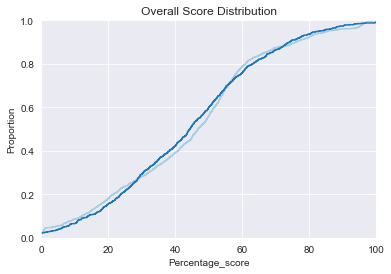

In [9]:
# Configuring some settings for the entire notebook
sns.set_palette("Paired")
sns.set_style("darkgrid")

# Plot the scores
ax = sns.ecdfplot(data=data, x="Percentage_score")

# Generate and plot a normally distributed sample with mean and std matching the data
mean_score, std_score = data.Percentage_score.mean(), data.Percentage_score.std()
g = sns.ecdfplot(ax=ax, x=np.random.normal(mean_score, std_score, size=1000))
g.set_title("Overall Score Distribution")
ax.set_xlim([0,100])

On first look the overall scores seem to be fairly close to a normal distribution but with a few noticeable deviations. Let's now see how it changes when we group the data by some of the other columns. 

### Gender

Text(0.5, 1.0, 'Scores by Gender')

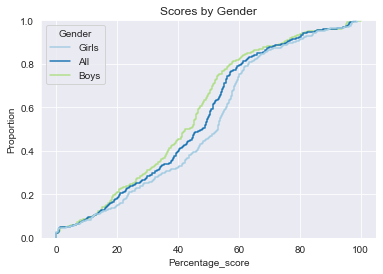

In [10]:
g=sns.ecdfplot(data=data, x="Percentage_score", hue="Gender")
g.set_title("Scores by Gender")

For gender, we see that boys schools perform worse than mixed schools and girls schools outperform mixed schools by a similar amount on average. The shape of each gendered distribution is more or less the same, and they start to merge towards the extremes. 


### Religion

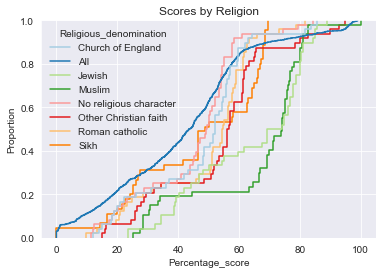

In [11]:
g=sns.ecdfplot(data=data, x="Percentage_score", hue="Religious_denomination")
g.set_title("Scores by Religion")
sns.move_legend(g, 'upper left', frameon=False)

In [12]:
# Check the median school size for each religion
data.groupby("Religious_denomination").Sample_size.median()

Religious_denomination
All                        4407.0
Church of England          2399.5
Jewish                       78.0
Muslim                       98.0
No religious character    34988.5
Other Christian faith       794.0
Roman catholic             3746.5
Sikh                         26.0
Name: Sample_size, dtype: float64

A lot of these distributions follow a similar shape, but the small sample size of most religions creates some shaky plots. 

When we look at religion, we have an interesting first observation that every religious school outperforms the mixed/non-religious schools on average. Most religions seem to perform similarly outside of muslim and jewish schools that skew towards much higher scores. These two religions also happen to have by far the smallest number of students per school along with Sikh schools, so this is not a perfectly fair comparison.

It's important to note the low sample size in general. We are aggregating pre-aggregated data rather than having access to individual student scores which reduces the number of data points significantly. As a result it's difficult to draw any major conclusions from this analysis. The significant majority of schools in our sample are listed as "all" for things like ethnicity and religion, making any other options quite volatile. Many schools also have a low number of students, allowing unusually high or low school averages to affect the data, and a lot of the specialist schools have this issue like we saw with religions above.

### Ethnicity
Let's try looking into the effect of ethnicity on scores.

In [13]:
# View the frequencies of each ethnicity
data.Ethnicity.value_counts()

All                                591
Unknown                             84
White                               84
Mixed                               83
Other                               83
Black                               81
Asian                               81
Chinese                             75
Mixed Other                          9
White Irish                          9
White British                        9
Pakistani                            9
Mixed White and Black Caribbean      9
Mixed White and Black African        9
Mixed White and Asian                9
Black Other                          9
Irish Traveller                      9
Indian                               9
Gypsy/Roma                           9
Black Caribbean                      9
Black African                        9
Bangladeshi                          9
Asian Other                          9
White Other                          9
Name: Ethnicity, dtype: int64

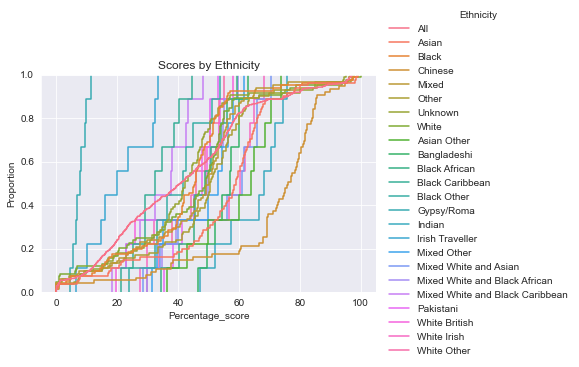

In [14]:
g=sns.ecdfplot(data=data, x="Percentage_score", hue="Ethnicity")
g.set_title("Scores by Ethnicity")
sns.move_legend(g, 'right',bbox_to_anchor=(1.6,0.5), frameon=False)

Clearly there are way too many ethnicities to make a clean comparison on one plot, and using subplots would just make the small differences harder to identify. In addition most of the ethnicities have a single digit number of schools, making the data quite unreliable. 

A lot of the ethnicity categories are quite specific, which we can try to merge together to create fewer, larger categories that look better on a plot. The british census informs some of these choices.

In [15]:
eth_dict = {"White British":"White", "White Irish": "White", "White Other": "White", "Black African": "Black", "Black Caribbean": "Black", "Black Other": "Black", "Asian Other": "Asian", "Mixed Other": "Mixed", "Mixed White and Asian":"Mixed", "Mixed White and Black African":"Mixed", "Mixed White and Black Caribbean":"Mixed", "Irish Traveller":"White", "Gypsy/Roma":"White", "Indian":"South Asian", "Bangladeshi": "South Asian", "Pakistani": "South Asian"}

# Replace the ethnicities as shown in the dictionary 
eth_data = data.replace({"Ethnicity":eth_dict})
eth_data.Ethnicity.value_counts()

All            591
White          129
Mixed          119
Black          108
Asian           90
Unknown         84
Other           83
Chinese         75
South Asian     27
Name: Ethnicity, dtype: int64

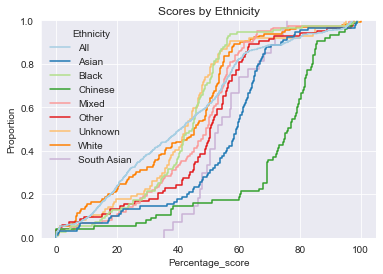

In [16]:
# Plot the new ethnicities
g=sns.ecdfplot(data=eth_data, x="Percentage_score", hue="Ethnicity")
g.set_title("Scores by Ethnicity")
sns.move_legend(g, 'upper left', frameon=False)

Now this is easier to interpret. The "all" category has worse average performance compared to single ethnicity schools but is not quite as far off as in the religion case. Again we see that most ethnicities sit within a reasonable range but with the Chinese performing much better. In general we notice that all Asian ethnicities seem to overperform.

### School Characteristic

One final category to consider as a factor is the type of school, stored as "School_characteristic".

In [17]:
# Check the frequencies of each type to better understand the analysis
data.School_characteristic.value_counts()

State-funded mainstream                 491
All state-funded                        384
Academies and free schools               54
Converter Academies                      54
LA maintained mainstream                 54
Sponsored Academies                      51
Free Schools                             51
University Technical Colleges (UTCs)     50
Studio Schools                           47
State-funded special schools             39
FE 14-16 Colleges                        31
Name: School_characteristic, dtype: int64

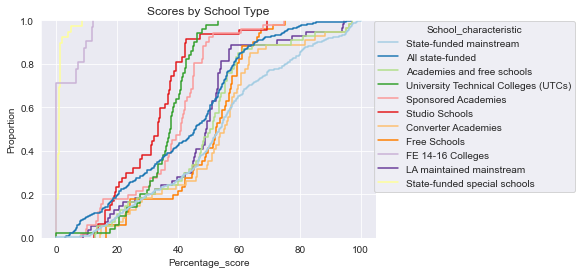

In [18]:
g=sns.ecdfplot(data=data, x="Percentage_score", hue="School_characteristic")
g.set_title("Scores by School Type")
sns.move_legend(g, 'right', bbox_to_anchor=(1.61,0.605))

We have a few outliers here. Both FE 14-16 Colleges and State-funded special schools score incredibly badly compared to all the others. State-funded mainstream schools perform the best overall, and there are two reasonably defined clumps that make up the other categories. 

UTCs, Studio schools and Sponsored Academies perform similarly with a median score sitting below 40. The remaining schools group around a median of 50, with similarly shaped distributions. 

## Hypothesis Testing

We have looked into a few visual comparisons between subcategories for various columns. These are great for getting a basic idea of how the scores can vary, but we can't make any confident conclusions without some proper statistical tests, especially when we consider the small sample size of certain subgroups.

To start with we will run a test that essentially tells us whether or not a particular column has a significant impact on the score. For all of our tests we will consider 0.01 as a fairly conservative significance threshold due to the sample sizes.

In [19]:
from scipy.stats import f_oneway

# Identify the columns we wish to investigate
features = eth_data.drop(["Percentage_score", "Sample_size"], axis=1)

# Test each column for significant impact on score
for col in features.columns:
    groups = data.groupby(col).Percentage_score
    samples = []
     
    # Set up a list of subgroups for the function to use
    for category in data[col].unique():
        samples.append(groups.get_group(category))

    print(col, "==>", f_oneway(*samples), "\n")

Ethnicity ==> F_onewayResult(statistic=8.086290880943624, pvalue=2.265196480167792e-25) 

Gender ==> F_onewayResult(statistic=6.223764170098944, pvalue=0.00204118570270119) 

FSM ==> F_onewayResult(statistic=26.559105417460735, pvalue=4.94805272493028e-12) 

SEN_type ==> F_onewayResult(statistic=110.90436614829011, pvalue=5.976044710740528e-64) 

SEN_grouping ==> F_onewayResult(statistic=56.49425878501315, pvalue=2.957138645261973e-24) 

Admission_type ==> F_onewayResult(statistic=116.27451076867362, pvalue=1.0275734505943537e-66) 

School_characteristic ==> F_onewayResult(statistic=46.33396452121111, pvalue=3.5709023680987873e-79) 

Religious_denomination ==> F_onewayResult(statistic=14.348245373814756, pvalue=4.646897491044656e-18) 



Based on these results, every column is worth investigating further. For the columns with just a few unique categories, we can perform pairwise tests on each pair to check for differences. For the other columns we have visualisations to help aid our decision making, and we will limit our tests to just a few of the most interesting comparisons.

### Gender

We will first consider the gender column since it is fairly simple. The most interesting difference is between the boy and girl subgroups, so we will perform a test to examine the significance of their mean difference. The sample sizes of each group are more than sufficient for this kind of test.

In [20]:
from scipy.stats import ttest_ind

ttest_ind(data.loc[data.Gender=="Boys", "Percentage_score"], data.loc[data.Gender=="Girls", "Percentage_score"], alternative="less")

Ttest_indResult(statistic=-3.5183817400379978, pvalue=0.00022839450248074983)

We find a p value of 0.0002. This is well below the 0.01 threshold so we find that there is indeed a significant difference in scores between schools with boys and those with girls, with the girls scoring better.

### Ethnicity

Next we will do the same for Ethnicity. There are a lot more categories in this column, so we will use our EDA visualisations to inform the pairs of groups that we compare. All ethnicities have just about enough observations to make our testing valid (>=27), though the South Asian category is very borderline. Based on our plot we saw that every single-ethnicity school seemed to have a mean score at least as large as the "All" ethnicity schools, so we will test every ethnicity against this to see if they are significantly better.

In [21]:
ethnicities = eth_data.groupby("Ethnicity").Percentage_score

for category in eth_data.Ethnicity.unique()[1:]:
    print(category+" > All ==>" , ttest_ind(ethnicities.get_group(category), ethnicities.get_group("All"), alternative="greater"), "\n")


Asian > All ==> Ttest_indResult(statistic=4.886792646724868, pvalue=6.399612348040751e-07) 

Black > All ==> Ttest_indResult(statistic=0.3194563669619284, pvalue=0.3747380981966548) 

Chinese > All ==> Ttest_indResult(statistic=9.5667611957906, pvalue=1.059246594931609e-20) 

Mixed > All ==> Ttest_indResult(statistic=1.7512776292994323, pvalue=0.04016555694645385) 

Other > All ==> Ttest_indResult(statistic=2.4170162569026674, pvalue=0.007956793142278398) 

Unknown > All ==> Ttest_indResult(statistic=0.16436026837696222, pvalue=0.43474844485809633) 

White > All ==> Ttest_indResult(statistic=-0.4501425925591109, pvalue=0.6736282478193462) 

South Asian > All ==> Ttest_indResult(statistic=3.0533991528917075, pvalue=0.0011801179107972203) 



Looks like a few ethnicities scored significantly better than the combined ethnicity schools: Asian, Chinese, Other, and South Asian. This suggests that the primary ethnicity of a school's students may influence the scores.

### SEN_type, SEN_grouping, Admission_type

We will not repeat the same lengthy justification and decision making for the next few columns, but instead perform the tests and summarise the results afterwards. We first create a quick function to perform pairwise testing on the columns with a reasonable amount of unique values. 

In [22]:
def pairwise_test(col):
    # Set up the subgroups of the column
    groups = data.groupby(col).Percentage_score
    
    # For each subgroup, test against every other subgroup
    for ind_a, category_a in enumerate(data[col].unique()):
        for ind_b, category_b in enumerate(data[col].unique()):
            # Avoid duplicate testing
            if ind_a >= ind_b:
                continue
            print(category_a+" vs "+category_b, "==>" ,ttest_ind(groups.get_group(category_a), groups.get_group(category_b), alternative="two-sided"), "\n")
    print("-----------------")        

In [23]:
for column in features.columns[3:6]:
    pairwise_test(column)

All vs SEN State EHC ==> Ttest_indResult(statistic=14.008103336733535, pvalue=3.188846382360143e-41) 

All vs No SEN ==> Ttest_indResult(statistic=-3.7481402715373684, pvalue=0.00018720262042308858) 

All vs SEN Supp ==> Ttest_indResult(statistic=10.290869754950593, pvalue=8.395504615567177e-24) 

SEN State EHC vs No SEN ==> Ttest_indResult(statistic=-17.5400017447801, pvalue=3.0934606233202443e-40) 

SEN State EHC vs SEN Supp ==> Ttest_indResult(statistic=-3.906093424127661, pvalue=0.00013330566567481162) 

No SEN vs SEN Supp ==> Ttest_indResult(statistic=14.34512549859651, pvalue=2.631927317247722e-31) 

-----------------
Any SEN vs No identified SEN ==> Ttest_indResult(statistic=-14.599568198441448, pvalue=2.3858485100341187e-31) 

Any SEN vs All ==> Ttest_indResult(statistic=-8.994736247441525, pvalue=8.799238341286455e-19) 

No identified SEN vs All ==> Ttest_indResult(statistic=4.721893555144321, pvalue=2.6071118407294383e-06) 

-----------------
All vs selective schools ==> Ttes

It appears that both the SEN related columns have significant score differences between every possible pairing within them. This suggests that the SEN classification of a school has a large impact on the score distribution of the students. The most significant differences seem to occur when comparing schools with no SEN and those with some kind of SEN, while the specific class of SEN is less important. We will learn more about the specific ranking of importance later.

For the school admission types we see the expected result that selective schools are significantly better scoring than any other. The differences between other types of school are not significant, except for a barely significant scoring discrepancy between non-selective schools that are in highly selective areas and those in other areas.  

### School Characteristic

For School characteristic we will use State-funded mainstream schools as a baseline, since they are the most populous category and these schools also seem to perform the best. We test each school type for significantly lower scores. We also ignore the two outliers of "FE 14-16 Colleges" and "State-funded special schools" since they are so far below the rest, having mostly 0 scores.

In [24]:
school_chars = data.groupby("School_characteristic").Percentage_score

for category in np.delete(data.School_characteristic.unique(), [0, 8, 10]):
    print(category+" < State-Funded Mainstream ==>" , ttest_ind(school_chars.get_group(category), school_chars.get_group("State-funded mainstream"), alternative="less"), "\n")


All state-funded < State-Funded Mainstream ==> Ttest_indResult(statistic=-7.670053694382775, pvalue=2.2928753658510075e-14) 

Academies and free schools < State-Funded Mainstream ==> Ttest_indResult(statistic=-1.4010023222574581, pvalue=0.08089230486974852) 

University Technical Colleges (UTCs) < State-Funded Mainstream ==> Ttest_indResult(statistic=-5.395540766559256, pvalue=5.123595682691207e-08) 

Sponsored Academies < State-Funded Mainstream ==> Ttest_indResult(statistic=-4.891202882484901, pvalue=6.621905307401389e-07) 

Studio Schools < State-Funded Mainstream ==> Ttest_indResult(statistic=-6.1713415668162686, pvalue=6.68315961255626e-10) 

Converter Academies < State-Funded Mainstream ==> Ttest_indResult(statistic=-0.3177449462739514, pvalue=0.37540028302684814) 

Free Schools < State-Funded Mainstream ==> Ttest_indResult(statistic=-1.4114563679310212, pvalue=0.0793429995365997) 

LA maintained mainstream < State-Funded Mainstream ==> Ttest_indResult(statistic=-2.02295353865369

All state-funded, UTCs, Sponsored Academies and Studio Schools are significantly lower scoring than the State-Funded Mainstream schools. This lines up with the plot, as the schools in the left "clump" along with the left-most member of the right "clump" are the significantly weaker schools. 

### Religion

Finally we run the same sort of tests for religions. Our baseline is the "All" category as with ethnicities. In this case the graph suggests that the single-religion schools outperform the "All" schools, so we check for any significantly higher scores.

In [25]:
religions = data.groupby("Religious_denomination").Percentage_score

for category in np.delete(data.Religious_denomination.unique(), 1):
    print(category+" > All ==>" , ttest_ind(religions.get_group(category), religions.get_group("All"), alternative="greater"), "\n")


Church of England > All ==> Ttest_indResult(statistic=1.6071504884301568, pvalue=0.054165424191224866) 

Jewish > All ==> Ttest_indResult(statistic=6.221620687386655, pvalue=3.5854474794394756e-10) 

Muslim > All ==> Ttest_indResult(statistic=6.8305534407726745, pvalue=7.261082164496555e-12) 

No religious character > All ==> Ttest_indResult(statistic=0.9659279880031171, pvalue=0.16715458675335626) 

Other Christian faith > All ==> Ttest_indResult(statistic=3.351389281495388, pvalue=0.0004167858460152265) 

Roman catholic > All ==> Ttest_indResult(statistic=2.1488210497774984, pvalue=0.015941703520949202) 

Sikh > All ==> Ttest_indResult(statistic=1.395264161649355, pvalue=0.08162039515500531) 



Jewish and Muslim schools perform significantly better than the baseline along with the "Other Christian faith" schools. The first two are clear from the graph, but the test revealed the third significant difference despite it having a score distribution quite close to some other schools.

### Hypothesis Testing Summary

From these results we see that every column has some significant differences in scores between categories, with some more significant than others, but this doesn't quite tell us how each column's influence compares precisely. If we want to find the feature that has the biggest impact on the final scores of a school, we have to keep digging into the data and try another approach.

## Finding the Most Impactful Features
We have seen how varying certain columns in our data can greatly influence the scores. Now we want to find out which of these columns actually contribute the most to the final scores. 

A nice way to estimate this is through feature selection for a machine learning model. This should automatically identify the features that act as the best predictors for the school scores. We can use sklearn to do this fairly simply, and we'll use the simplified ethnicity data here.

First we need to transform our many categorical columns to dummies for the functions to work properly. We then use one of the feature selection functions to identify the top 25%. 

In [26]:
# Create dummies for all relevant columns
dum_data = pd.get_dummies(eth_data, columns=list(eth_data.columns)[:8], prefix_sep="__")
dum_data.head()


,Percentage_score,Sample_size,Ethnicity__All,Ethnicity__Asian,Ethnicity__Black,Ethnicity__Chinese,Ethnicity__Mixed,Ethnicity__Other,Ethnicity__South Asian,Ethnicity__Unknown,...,School_characteristic__Studio Schools,School_characteristic__University Technical Colleges (UTCs),Religious_denomination__All,Religious_denomination__Church of England,Religious_denomination__Jewish,Religious_denomination__Muslim,Religious_denomination__No religious character,Religious_denomination__Other Christian faith,Religious_denomination__Roman catholic,Religious_denomination__Sikh
0,20.9,1577,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,57.1,26852,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,59.8,13665,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,17.8,2488,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,14.9,450,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### Most Impactful Subgroups

Due to the use of dummy columns, the first result we will find is going to be based on subgroups of each column rather than the original columns themselves. This is still useful, but we will investigate the actual columns later.

In [27]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression

# Use a regression model to identify features that predict scores the best
opt = SelectPercentile(f_regression, percentile=25)
opt.fit_transform(dum_data.iloc[:, 2:], dum_data.iloc[:, 0])

# Display the data with just the selected columns
dum_data.iloc[:, 2:].loc[:, opt.get_support()]

,Ethnicity__Chinese,SEN_type__All,SEN_type__SEN State EHC,SEN_type__SEN Supp,SEN_grouping__Any SEN,Admission_type__All,Admission_type__selective schools,School_characteristic__FE 14-16 Colleges,School_characteristic__State-funded mainstream,School_characteristic__State-funded special schools,Religious_denomination__All
0,0,1,0,0,1,1,0,0,1,0,0
1,0,1,0,0,0,1,0,0,1,0,0
2,0,1,0,0,0,1,0,0,1,0,0
3,0,1,0,0,1,1,0,0,1,0,0
4,0,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1346,0,1,0,0,0,1,0,0,0,0,1
1347,0,1,0,0,0,1,0,0,0,0,1
1348,0,1,0,0,0,1,0,0,0,0,1
1349,0,1,0,0,0,1,0,0,0,0,1


The above subgroupings of columns should be the best predictors of school scores. These are not ordered or clear, which we will take care of now.

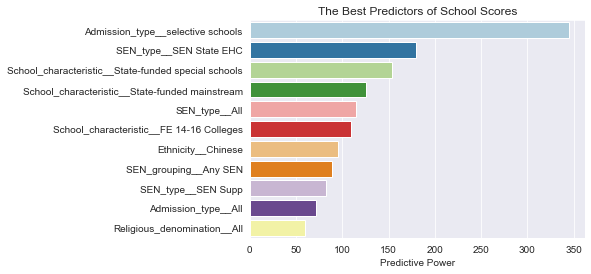

In [28]:
# Sort the results, only including the top columns and adding them to a dataframe
results = sorted(list(zip(opt.scores_[opt.get_support()], dum_data.iloc[:, 2:].loc[:, opt.get_support()].columns)), reverse=True)
results_df = pd.DataFrame(results, columns=["Predictive Power", "Feature"])

# Plot the best predictive features
g = sns.barplot(data=results_df, x="Predictive Power", y="Feature")
g.set(ylabel="")
g.set_title("The Best Predictors of School Scores")
plt.show()

We now have a sorted plot of top features, with a higher score being better. By far the most impactful variable is whether or not a school is selective. This makes sense since we would expect schools that limit their admissions to only the best students to also produce the best results. 

In the remaining rankings, we find that SEN_type and School_characteristic dominate, with a single ethnicity and religion subgroup appearing. 

### Most Impactful Columns

While the above graph shows the finer details of the categories from each column with the most impact, it would be visually clearer to return to the original columns and compute a column-wise analysis of prediction strength. Let's see how things look if we use the average prediction scoring of each column.

In [29]:
# Repeat the process but keep all columns this time
opt_full = SelectPercentile(f_regression, percentile=100)
opt_full.fit_transform(dum_data.iloc[:, 2:], dum_data.iloc[:, 0])

# Sort the entire list of resulting column scores into a dataframe
results_full = sorted(list(zip(opt_full.scores_[opt_full.get_support()], dum_data.iloc[:, 2:].loc[:, opt_full.get_support()].columns)), reverse=True)
results_full_df = pd.DataFrame(results_full, columns=["Predictive Power", "Feature_subgroup"])

# Extract the original column from each subgroup for aggregation
results_full_df["Feature"] = results_full_df["Feature_subgroup"].str.split("__").apply(lambda x: x[0])
results_full_df.head(20)

,Predictive Power,Feature_subgroup,Feature
0,344.752179,Admission_type__selective schools,Admission_type
1,179.578047,SEN_type__SEN State EHC,SEN_type
2,153.772742,School_characteristic__State-funded special sc...,School_characteristic
3,125.763176,School_characteristic__State-funded mainstream,School_characteristic
4,115.049391,SEN_type__All,SEN_type
5,109.186893,School_characteristic__FE 14-16 Colleges,School_characteristic
6,95.571230,Ethnicity__Chinese,Ethnicity
7,88.386143,SEN_grouping__Any SEN,SEN_grouping
8,82.829118,SEN_type__SEN Supp,SEN_type
9,71.780373,Admission_type__All,Admission_type


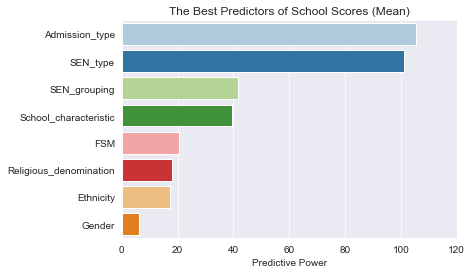

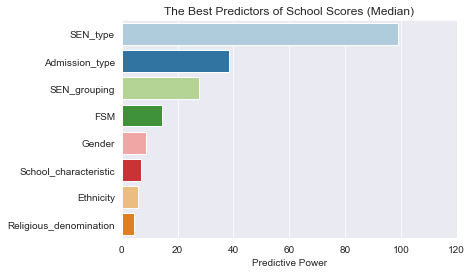

In [34]:
# Grouping by feature and computing both mean and median seperately for simpler plot ordering

grouped = results_full_df.groupby("Feature")["Predictive Power"]
means = grouped.mean().sort_values(ascending=False)
medians = grouped.median().sort_values(ascending=False)

# Plotting the aggregations using the above for properly ordered bars

means_plot = sns.barplot(data=results_full_df, x="Predictive Power", y="Feature", ci=None, order=means.index)
means_plot.set(ylabel="")
means_plot.set_title("The Best Predictors of School Scores (Mean)")
means_plot.set_xlim([0,120])
plt.show()

medians_plot = sns.barplot(data=results_full_df, x="Predictive Power", y="Feature", ci=None, order=medians.index, estimator=np.median)
medians_plot.set(ylabel="")
medians_plot.set_title("The Best Predictors of School Scores (Median)")
medians_plot.set_xlim([0,120])
plt.show()

The two graphs show how the rankings average out by column, using both mean and median as an aggregator. 

We can see how the extreme values influence the means, with the top order being mostly reflective of the top features we looked at earlier. The median graph shows a big drop from Admission_type and School_characteristic especially, since most of their value came from a single subgroup.

Importantly the top 3 columns stayed the same between plots, despite the order shifting a little. This leads us to conclude that the top 3 most impactful features are as follows, in order:

- SEN_type
- Admission_type
- SEN_grouping

## Conclusion

Throughout this analysis we looked at how various factors influence school scores. While plenty of things like Ethnicity, Religion, and Gender had a meaningful effect on scores, the factors with the most impact were actually administrative choices. 

In particular, the admission criteria of a school is important, as well as the extent to which the school supports and accomodates SEN students (Special Educational Needs).